In [2]:
import torch
import torch.nn as nn
import os
import pandas as pd
import skimage as sk
from skimage import io as skio, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import time
import xml.etree.ElementTree as ET 
import torchvision.models as models
from PIL import Image # to read images

In [3]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['pts']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]
        sample['image'] = img
        sample['pts'] = landmarks
        return sample

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['pts']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
#         image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        image = torch.unsqueeze(image, 0)
        sample['image'] = image
        sample['pts'] = torch.from_numpy(landmarks)
        return sample

In [ ]:
# Part 1 Dataloader
dataset = FacePointsDataset('imm_face_db', transforms.Compose([Rescale((60,80)), ToTensor()]))
dataloader = DataLoader(dataset)

In [ ]:
class NosePrintLayer(nn.Module):
    def __init__(self):
        super(NosePrintLayer, self).__init__()
    
    def forward(self, x):
#         print(x.shape)
        return x

In [ ]:
class ViewLayer(nn.Module):
    def __init__(self):
        super(ViewLayer, self).__init__()
    
    def forward(self, x):
        x = x.view(1, -1)
        return x

In [ ]:
# Define CNN for just the Nose Keypoint
class NoseNet(nn.Module):
    def __init__(self):
        super(NoseNet, self).__init__()
        self.channels = 20
        self.kernel_size = 3
        pad = 1
        stride = 1
        self.layers = nn.Sequential(
            nn.Conv2d(1, self.channels, self.kernel_size, padding=pad, stride=stride),
            NosePrintLayer(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(self.channels, self.channels*2, self.kernel_size, padding=pad, stride=stride),
            NosePrintLayer(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(self.channels*2, self.channels*3, self.kernel_size, padding=pad, stride=stride), 
            NosePrintLayer(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Not sure about input size here
            ViewLayer(),
            nn.Linear(self.channels*210, 500),
            NosePrintLayer(),
            nn.ReLU(inplace=True),
            nn.Linear(500, 2),
            NosePrintLayer(),
        )

    def forward(self, x):
        x = self.layers(x)
        return x



In [ ]:
# Define loss_fn
loss_fn = nn.MSELoss(reduction='sum')

In [ ]:
def nose_train(net, optimizer, dataloader, loss_fn):
    total_loss = 0
    net = net.train()
    cnt = 0
    for i_batch, sample_batched in enumerate(dataloader):
        im = sample_batched['image']
        pts = sample_batched['pts']
        optimizer.zero_grad()
        output = net(im)
        loss = loss_fn(output, pts)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        cnt += 1
    return total_loss/cnt

In [ ]:
def display_im(im, pred_pts, act_pts, h, w):
    print(pred_pts)
    print(act_pts)
    plt.figure()
    plt.imshow(im[0][0], cmap='gray')
    plt.scatter(pred_pts[0][0], pred_pts[0][1], s=10, marker='.', c='r')
    plt.scatter(act_pts[0][0], act_pts[0][1], s=10, marker='.', c='g')
    plt.show()

In [ ]:
def nose_validation(net, dataloader, loss_fn, epoch):
    losses = 0
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for i_batch, sample_batched in enumerate(dataloader):
            im = sample_batched['image']
            pts = sample_batched['pts']
            h = sample_batched['h']
            w = sample_batched['w']
            output = net(im)
            if epoch == 9 and cnt < 7:
                display_im(im, output, pts, h, w)
            loss = loss_fn(output, pts)
            losses += loss.item()
            cnt += 1
    print(losses/cnt)
    return losses/cnt

In [ ]:
# Training code for epochs
train_dataset = FacePointsDataset('imm_face_db', transforms.Compose([Rescale((60,80)), ToTensor()]))
train_dataloader = DataLoader(train_dataset)

val_dataset = FacePointsDataset('imm_face_db', transforms.Compose([Rescale((60,80)), ToTensor()]), val=True)
val_dataloader = DataLoader(val_dataset)

In [ ]:
plt.plot(range(10), train_losses, label='Training Loss')
plt.plot(range(10), val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during Training and Validation over Time')

In [ ]:
print(train_losses)

[0.15701740609662568, 0.17203027709048985, 0.17206094224823873, 0.1550601521307927, 0.13176444531959733, 0.16973926884990692, 0.2450708088957308, 0.21515038496838046, 0.10454468770769695, 0.06989717450926972]


#### It fails for the images where the face is angled. This may be due to the limited amount of training data, due to which the model is unable to handle outlier cases where the head is angled in an unexpected way

In [ ]:
# Define CNN for full face
class FullNet(nn.Module):
    def __init__(self):
        super(FullNet, self).__init__()
        self.channels = 25
        self.kernel_size = 3
        pad = 1
        stride = 1
        self.layers = nn.Sequential(
            nn.Conv2d(1, self.channels, self.kernel_size, padding=pad, stride=stride),
            PrintLayer(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(self.channels, self.channels*2, self.kernel_size, padding=pad, stride=stride),
            PrintLayer(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(self.channels*2, self.channels*4, self.kernel_size, padding=pad, stride=stride), 
            PrintLayer(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(self.channels*4, self.channels*8, self.kernel_size, padding=pad, stride=stride), 
            PrintLayer(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(self.channels*8, self.channels*16, self.kernel_size, padding=pad, stride=stride), 
            PrintLayer(),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Not sure about input size here
            ViewLayer(),
            nn.Linear(6000, 2000),
            PrintLayer(),
            nn.ReLU(inplace=True),
            nn.Linear(2000, 600),
            nn.ReLU(inplace=True),
            nn.Linear(600, 116),
            PrintLayer(),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [ ]:
def full_train(net, optimizer, dataloader, loss_fn):
    total_loss = 0
    net = net.train()
    cnt = 0
    for i_batch, sample_batched in enumerate(dataloader):
        im = sample_batched['image']
        pts = sample_batched['pts']
        optimizer.zero_grad()
        output = net(im)
        output = output.view(58, -1)
        output = torch.unsqueeze(output, 0)
        loss = loss_fn(output, pts)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        cnt += 1
    return total_loss/cnt

In [ ]:
def full_validation(net, dataloader, loss_fn, epoch):
    losses = 0
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for i_batch, sample_batched in enumerate(dataloader):
            im = sample_batched['image']
            pts = sample_batched['pts']
            h = sample_batched['h']
            w = sample_batched['w']
            output = net(im)
            output = output.view(58, -1)
            output = torch.unsqueeze(output, 0)
            if epoch == 0 and cnt < 7:
                full_display_im(im, output, pts, h, w)
            loss = loss_fn(output, pts)
            losses += loss.item()
            cnt += 1
    print(losses/cnt)
    return losses/cnt

In [ ]:
def full_display_im(im, pred_pts, act_pts, h, w):
#     pred_pts = np.array([[i[0]*w, i[1]*h] for i in pred_pts[0]])
#     act_pts = np.array([[i[0]*w, i[1]*h] for i in act_pts[0]])
    plt.figure()
    plt.imshow(im[0][0], cmap='gray')
    plt.scatter(pred_pts[:,0], pred_pts[:,1], s=10, marker='.', c='r')
    plt.scatter(act_pts[:,0], act_pts[:,1], s=10, marker='.', c='g')
    plt.show()

In [ ]:
# Training code for epochs
full_train_dataset = FacePointsDataset('imm_face_db', transforms.Compose([Rescale((120,160)), ToTensor()]), nose=False)
full_train_dataloader = DataLoader(full_train_dataset)

full_val_dataset = FacePointsDataset('imm_face_db', transforms.Compose([Rescale((120,160)), ToTensor()]), nose=False, val=True)
full_val_dataloader = DataLoader(full_val_dataset)

In [ ]:
class ViewLayer(nn.Module):
    def __init__(self):
        super(ViewLayer, self).__init__()
    
    def forward(self, x):
        x = x.view(1, -1)
        return x

class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
    #         print(x.shape)
        return x

In [5]:
# Part 3: Train with Larger Dataset

%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'

In [6]:
tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32') 

In [23]:
class FacePointsDataset(Dataset):
    def __init__(self, img_filenames, landmarks, bboxes, transform=None, num=None, test=False):
        self.transform = transform
        self.num = num
        if not self.num:
          self.num = len(img_filenames)
        self.test = test
        self.img_filenames = img_filenames[0:self.num]
        self.landmarks = landmarks[0:self.num]
        self.bboxes = bboxes[0:self.num]
        if self.test:
          self.items = [self.get_test(index) for index in range(len(self.img_filenames))]
        else:
          self.items = [self.get(index) for index in range(len(self.img_filenames))]

    def get_test(self, index):
        if index >= len(self.img_filenames):
            return None
        file = self.img_filenames[index]
        im = skio.imread(file, as_gray=True)
        im = (sk.img_as_float32(im)) - 0.5
        new_im, tmp_pts = self.crop_box(index, im, [[1,1]])
        h, w = im.shape[:2]
        ans = {'image': new_im, 'pts': tmp_pts, 'h': h, 'w': w, 'box': self.bboxes[index]}
        if self.transform:
            ans = self.transform(ans)
        return ans

    def get(self, index):
        if index >= len(self.img_filenames):
            return None
        file = self.img_filenames[index]
        im = skio.imread(file, as_gray=True)
        im = (sk.img_as_float32(im)) - 0.5
        tmp_pts = self.landmarks[index]
        im, tmp_pts = self.crop_box(index, im, tmp_pts)
        h, w = im.shape[:2]
        ans = {'image': im, 'pts': tmp_pts, 'h': h, 'w': w, 'box': self.bboxes[index]}
        if self.transform:
            ans = self.transform(ans)
        return ans

    def crop_box(self, index, im, landmark):
        box = self.bboxes[index]
        x0 = int(max(box[0], 0))
        y0 = int(max(box[1], 0))
        width = int(box[2]*1.4)
        height = int(box[3]*1.4)
        final_landmarks = []
        for pair in landmark:
          pair_0 = pair[0] - x0
          pair_1 = pair[1] - y0
          final_landmarks.append([pair_0, pair_1])
        final_landmarks = np.array(final_landmarks).astype('float32')
        return im[y0:y0+height, x0:x0+width], final_landmarks
    def get_img_filenames(self):
        return [file for file in os.listdir(self.dir_path) if file.endswith(".jpg")]
    
    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, index):
        return self.items[index]

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
full_train_dataset = FacePointsDataset(img_filenames, landmarks, bboxes, transforms.Compose([Rescale((224,224)), ToTensor()]))
full_train_dataloader = DataLoader(full_train_dataset)

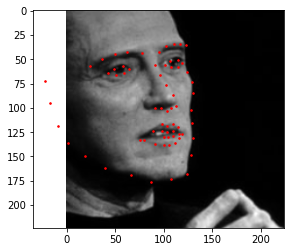

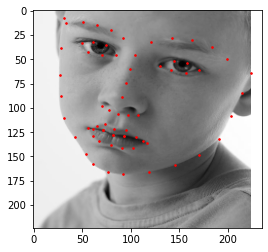

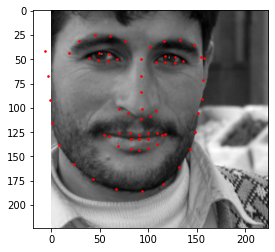

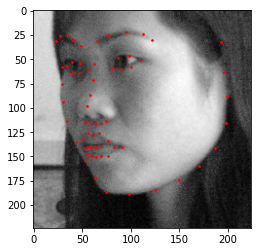

In [ ]:
count = 0
for i_batch, sample_batched in enumerate(full_train_dataloader):
    plt.figure()
    plt.imshow(sample_batched['image'][0][0], cmap='gray')
    plt.scatter(sample_batched['pts'][0][:,0], sample_batched['pts'][0][:,1], s=10, marker='.', c='r')
    plt.show()
    count += 1
    if count > 3:
        break

In [8]:
resnet18 = models.resnet18()
resnet18.conv1 = torch.nn.Conv2d(1,64, kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
resnet18.fc = torch.nn.Linear(512 * resnet18.layer1[0].expansion,68*2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
def part3_train(net, optimizer, dataloader, loss_fn, device):
    total_loss = 0
    net = net.train()
    cnt = 0
    for i_batch, sample_batched in enumerate(dataloader):
        im = sample_batched['image']
        im = im.to(device, dtype=torch.float)
        pts = sample_batched['pts']
        pts = pts.to(device, dtype=torch.float)
        optimizer.zero_grad()
        output = net(im)
        output = output.view(68, -1)
        output = torch.unsqueeze(output, 0)
        loss = loss_fn(output, pts)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        cnt += 1
    return total_loss/cnt

In [ ]:
def part3_validation(net, dataloader, loss_fn, epoch):
    losses = 0
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for i_batch, sample_batched in enumerate(dataloader):
            im = sample_batched['image']
            pts = sample_batched['pts']
            h = sample_batched['h']
            w = sample_batched['w']
            output = net(im)
            output = output.view(68, -1)
            output = torch.unsqueeze(output, 0)
            if epoch == 0 and cnt < 7:
                full_display_im(im, output, pts, h, w)
            loss = loss_fn(output, pts)
            losses += loss.item()
            cnt += 1
    print(losses/cnt)
    return losses/cnt

In [22]:
net = resnet18
net = net.to(device, dtype=torch.float)
# Define loss_fn
loss_fn = nn.MSELoss(reduction='sum')
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
start = time.time()
train_losses = []
val_losses = []
for epoch in range(30):
    train_losses.append(part3_train(net, optimizer, full_train_dataloader, loss_fn, device))
    # val_losses.append(full_validation(net, full_val_dataloader, loss_fn, epoch))
end = time.time()
print("time= " + str(end-start))

time= 3404.523794412613


In [23]:
torch.save(net.state_dict(), 'drive/My Drive/save_best')

In [12]:
resnet18.load_state_dict(torch.load('drive/My Drive/save_best'))
net = resnet18
net = net.to(device, dtype=torch.float)


In [9]:
# Load in test images
%%capture
!wget 'https://inst.eecs.berkeley.edu/~cs194-26/fa20/hw/proj4/labels_ibug_300W_test_parsed.xml'


In [10]:
test_tree = ET.parse('labels_ibug_300W_test_parsed.xml')
test_root = test_tree.getroot()

test_bboxes = [] # face bounding box used to crop the image
test_img_filenames = [] # the image names for the whole dataset

for filename in test_root[2]:
	test_img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	test_bboxes.append([box['left'], box['top'], box['width'], box['height']]) 
     
test_bboxes = np.array(test_bboxes).astype('float32') 

In [ ]:
test_dataset = FacePointsDataset(test_img_filenames, [], test_bboxes, transforms.Compose([Rescale((224,224)), ToTensor()]), test=True)
test_dataloader = DataLoader(test_dataset)

In [15]:
result = []
with torch.no_grad():
    net = net.eval()
    for i_batch, sample_batched in enumerate(test_dataloader):
        im = sample_batched['image'].to(device)
        h = sample_batched['h']
        w = sample_batched['w']
        box = sample_batched['box']
        width = int(box[0][2]*1.4)
        height = int(box[0][3]*1.4)
        output = net(im)
        output = output.view(68, -1)
        for i in output:
          result.append((i[0].item() * (width/224) + max(box[0][0].item(),0) + 0.5))
          result.append((i[1].item() * (height/224) + max(box[0][1].item(),0) + 0.5))


In [33]:
print(result)

[146.77085876464844, 324.9065246582031, 142.0923614501953, 348.266357421875, 142.42633056640625, 369.9949645996094, 148.65789794921875, 396.49224853515625, 154.80874633789062, 419.87371826171875, 165.3312225341797, 444.06402587890625, 172.49868774414062, 465.39666748046875, 178.92396545410156, 487.6248779296875, 191.1917724609375, 505.1264343261719, 215.61868286132812, 513.6500854492188, 253.62615966796875, 511.51531982421875, 293.314697265625, 500.37042236328125, 335.23406982421875, 483.7773742675781, 368.0615539550781, 459.485107421875, 385.6600036621094, 427.5941467285156, 396.37408447265625, 390.916015625, 404.42437744140625, 354.21673583984375, 125.03831481933594, 303.66375732421875, 133.91416931152344, 289.89483642578125, 153.13119506835938, 288.09130859375, 173.27371215820312, 296.0452880859375, 190.89154052734375, 311.383056640625, 205.7082977294922, 311.92144775390625, 239.56544494628906, 300.3358154296875, 276.29998779296875, 297.723876953125, 310.3942565917969, 308.927154541

In [30]:
import pandas as pd
df = pd.DataFrame(result).to_csv("test.csv")


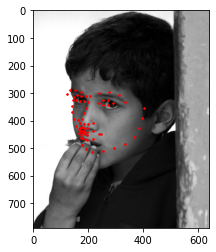

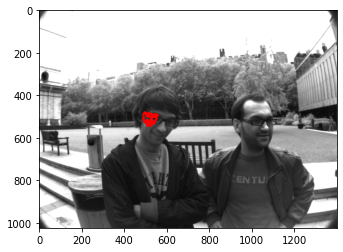

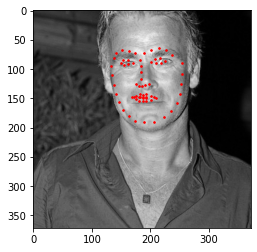

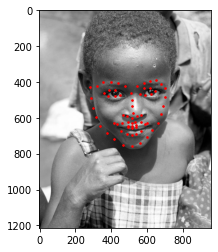

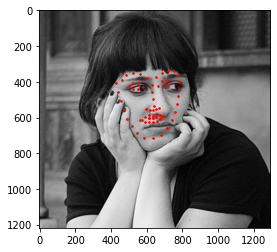

In [22]:
result = []
with torch.no_grad():
    net = net.eval()
    count = 0
    for i_batch, sample_batched in enumerate(test_dataloader):
        im = sample_batched['image'].to(device)
        h = sample_batched['h']
        w = sample_batched['w']
        box = sample_batched['box']
        width = int(box[0][2]*1.4)
        height = int(box[0][3]*1.4)
        output = net(im)
        output = output.view(68, -1)
        pred_pts = np.array([[(i[0].item() * (width/224) + max(box[0][0].item(),0)), (i[1].item() * (height/224) + max(box[0][1].item(),0))] for i in output])
        plt.figure()
        old_im = sample_batched['old_im']
        plt.imshow(old_im[0], cmap='gray')
        plt.scatter(pred_pts[:,0], pred_pts[:,1], s=10, marker='.', c='r')
        plt.show()
        count += 1
        if count > 4:
          break